# Homework 6

Dataset

In this homework, we will use the California Housing Prices from Kaggle.

https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').
Preparing the dataset

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.


In [1]:
# IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

c:\Users\daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(data)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df = df[df['ocean_proximity'].isin(['INLAND', '<1H OCEAN'])]

In [5]:
df.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64

In [6]:
df.fillna(0, inplace=True)

In [7]:
df.median_house_value = np.log1p(df.median_house_value)

In [8]:
df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [10]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

 - Train a model with max_depth=1.

Which feature is used for splitting the data?

In [11]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Question 2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [16]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [17]:
y_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

In [20]:
print(round(rmse,3))

0.245


Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

In [28]:
scores= []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    scores.append((n, rmse))

In [29]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores.head()

,n_estimators,rmse
0,10,0.244600
1,20,0.237804
2,30,0.236207
3,40,0.234715
4,50,0.234576


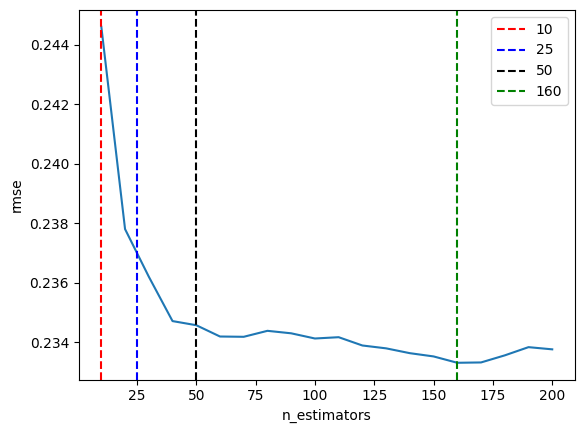

In [30]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.axvline(10, linestyle= '--', color='r', label=10)
plt.axvline(25, linestyle= '--', color='b', label=25)
plt.axvline(50, linestyle= '--', color='k', label=50)
plt.axvline(160, linestyle= '--', color='g', label=160)

plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.legend()
plt.show()

Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values

        - try different values of n_estimators from 10 till 200 (with step 10)
        - calculate the mean RMSE
- Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

In [31]:
scores = []

for d in [10,15,20,25]:
    for n in range(10,201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val,y_pred)
        rmse = np.sqrt(mse)
        
        scores.append((d,n,rmse))

In [33]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators','max_depth', 'rmse'])
df_scores.head()

,n_estimators,max_depth,rmse
0,10,10,0.250510
1,10,20,0.247411
2,10,30,0.246377
3,10,40,0.245170
4,10,50,0.245689


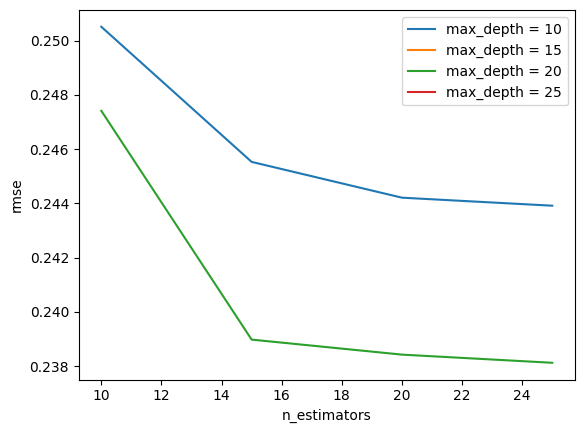

In [34]:
for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label = 'max_depth = %d' % d)

plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.legend()
plt.show()

Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:


* Train the model with these parameters:
    * n_estimators=10,
    * max_depth=20,
    * random_state=1,
    * n_jobs=-1 (optional)
* Get the feature importance information from this model

What's the most important feature (among these 4)?


In [35]:
new_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
new_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [36]:
new_model.feature_importances_

array([0.01504314, 0.03006329, 0.10266505, 0.08585341, 0.33548579,
       0.21881985, 0.14745955, 0.02811472, 0.01543366, 0.02106153])

In [39]:
dv.feature_names_

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [37]:
idx_max = np.argmax(new_model.feature_importances_)

In [38]:
dv.get_feature_names_out()[idx_max]

'median_income'

Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

In [40]:
dtrain = xgb.DMatrix(X_train, label = y_train )
dval = xgb.DMatrix(X_val, label=y_val)

In [41]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [42]:
scores = {}

In [46]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
xgb.train(xgb_params, dtrain, num_boost_round = 100 , evals= watchlist )

In [44]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))


    columns = ['num_iter','train_rmse','val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [47]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

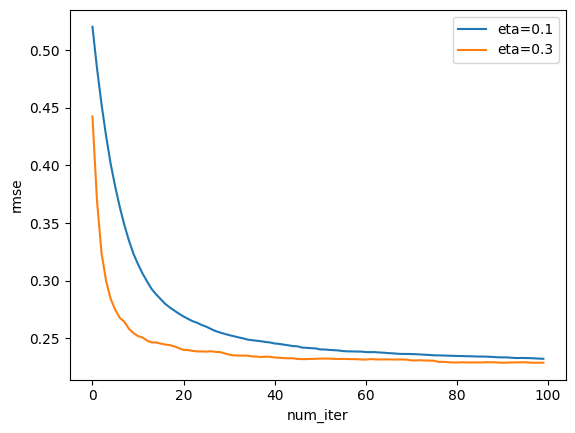

In [48]:
etas = ['eta=0.1', 'eta=0.3']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_rmse, label = eta)

plt.xlabel('num_iter')
plt.ylabel('rmse')
plt.legend()
plt.show()